In [95]:
%pip install matplotlib pandas duckdb


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<br><br><br>

# [LA] Issued Building Permits: Read and Merge

All 3 of these datasets need to be combined:

* [LADBS - Building Permits Issued from 2020 to Present (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-from-2/pi9x-tg5x/about_data "Building and Safety - Building Permits Issued from 2020 to Present (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Between 2010 and 2019 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Betwee/dyxf-7hc4/about_data "Building and Safety - Building Permits Issued Between 2010 and 2019 (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Before 2010 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Before/e67z-kt2n/about_data "Building and Safety - Building Permits Issued Before 2010 (N) | Los Angeles - Open Data Portal")

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.


In [88]:
import pandas as pd
import duckdb

file_paths = [
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Before_2010__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Between_2010_and_2019__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_from_2020_to_Present__N__20250810.csv',
]
date_fields = ['SUBMITTED_DATE', 'ISSUE_DATE', 'COFO_DATE', 'STATUS_DATE']
permits_lacity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_lacity['issue_year'] = permits_lacity['ISSUE_DATE'].dt.year
print(permits_lacity.dtypes)

/tmp/ipykernel_15607/3421569200.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
/tmp/ipykernel_15607/3421569200.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


PERMIT_NBR                 object
PRIMARY_ADDRESS            object
ZIP_CODE                  float64
CD                        float64
PIN_NBR                    object
APN                        object
ZONE                       object
APC                        object
CPA                        object
CNC                        object
HL                         object
CT                         object
PERMIT_GROUP               object
PERMIT_TYPE                object
PERMIT_SUB_TYPE            object
USE_CODE                  float64
USE_DESC                   object
SUBMITTED_DATE     datetime64[ns]
ISSUE_DATE         datetime64[ns]
COFO_DATE          datetime64[ns]
DU_CHANGED                float64
ADU_CHANGED               float64
JUNIOR_ADU                float64
SQUARE_FOOTAGE            float64
STATUS_DESC                object
STATUS_DATE                object
VALUATION                 float64
CONSTRUCTION               object
HEIGHT                    float64
TYPE_LAT_LON  

<br><br><br>

# [LA] Annotate permits with ADU hints:

* `certainly_adu` - explicitly marked as an ADU via `use_desc` code.
* `probably_adu` - only marked using a residential-type code, but the long description clearly indicates that it is for an ADU.

In [93]:
sql_string = """
SELECT *,

       use_desc in (
         'Accessory Dwelling Unit',
         'Junior Accessory Dwelling Unit'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as certainly_adu,
    
       use_desc in (
         'Apartment',
         'Duplex',
         'Dwelling - Single Family',
         'Garage - Private'
       ) and (
            work_desc ilike '%(n) adu%'
         or work_desc ilike '%new adu%'
         or work_desc ilike '%one adu%'
         or work_desc ilike '%(n) (% sf) adu%'
         or work_desc ilike '%new (% sf) adu%'
         or work_desc ilike '%one (% sf) adu%'
         or work_desc ilike '%(n) accessory dwelling unit%'
         or work_desc ilike '%new accessory dwelling unit%'
         or work_desc ilike '%one accessory dwelling unit%'
         or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
         or work_desc ilike '%new (% sf) accessory dwelling unit%'
         or work_desc ilike '%one (% sf) accessory dwelling unit%'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as probably_adu
    
FROM permits_lacity
"""

permits_lacity = duckdb.query(sql_string).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<br><br><br>

# [LA] Try to identify trends between certainly/probably ADUs.

<Axes: xlabel='issue_year'>

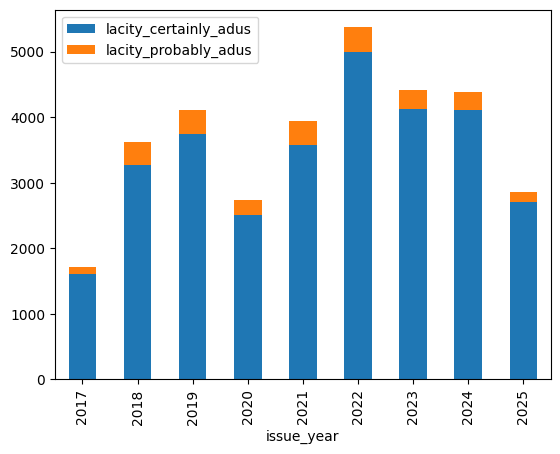

In [113]:
sql_string = """
  SELECT issue_year,
         sum(certainly_adu) as lacity_certainly_adus,
         sum(probably_adu) as lacity_probably_adus,
         sum(certainly_adu) + sum(probably_adu) as lacity_all_adus
    FROM permits_lacity
   WHERE (certainly_adu or probably_adu)
     AND issue_year >= 2017
group by issue_year
order by issue_year
"""

lacity_adu_permits_issued_by_year = duckdb.query(sql_string).df()
lacity_adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_certainly_adus', 'lacity_probably_adus'], kind='bar', stacked=True)

<Axes: xlabel='issue_year'>

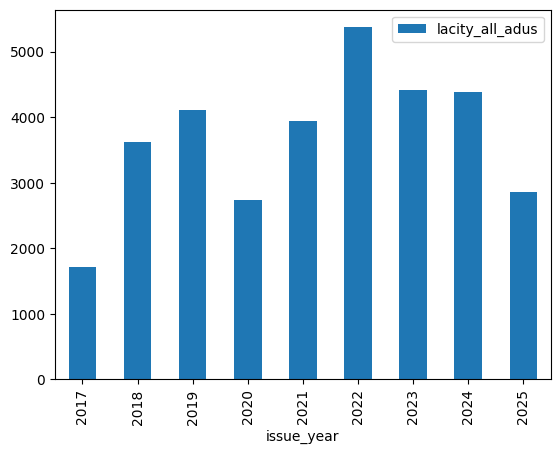

In [115]:
lacity_adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_all_adus'], kind='bar')

<br><br><br>

# [LA + Sac] Early comparison of issued ADU permits

Sacramento city staff published historic annual counts for ADU permits issued in their [2024 Housing Element Annual Progress Report](https://sacramento.granicus.com/MetaViewer.php?view_id=21&event_id=5356&meta_id=820912#page=7). Assuming these numbers are comparable to mine for LA, then plotting the two cities side-by-side could be useful. 

<Axes: xlabel='issue_year'>

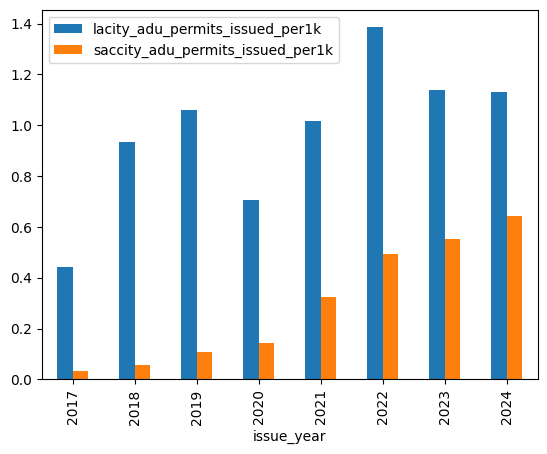

In [120]:
##############################
# Copy Sac data from report. #
##############################
saccity_adu_permits_issued = pd.DataFrame(
    data={
      'issue_year': [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      'saccity_all_adus': [18, 30, 57, 76, 170, 259, 291, 338],
    },
)
all_cities_adu_permits_issued_by_year = lacity_adu_permits_issued_by_year.merge(saccity_adu_permits_issued)

############################
# Normalize by population. #
############################
lacity_population = 3878704
saccity_population = 526327

all_cities_adu_permits_issued_by_year['lacity_adu_permits_issued_per1k'] = (
    all_cities_adu_permits_issued_by_year['lacity_all_adus'] / lacity_population * 1000
)
all_cities_adu_permits_issued_by_year['saccity_adu_permits_issued_per1k'] = (
    all_cities_adu_permits_issued_by_year['saccity_all_adus'] / saccity_population * 1000
)

#########
# Plot. #
#########
all_cities_adu_permits_issued_by_year.plot(
    x='issue_year',
    y=['lacity_adu_permits_issued_per1k', 'saccity_adu_permits_issued_per1k'],
    kind='bar'
)

<br><br><br>

# Los Angeles Issued ADU Permits: Sample Descriptions

Permit descriptios could contain the clues needed to identify Los Angeles ADU permits using pre-approved plans (vs. non-pre-approved).

Unfortunately, I can't find any pattern in the noise. Sacramento building department staff do better job at including certain key words like "shelf-ready ADU" in their descriptions.

In [119]:
sql_string = """
SELECT year("ISSUE_DATE") as issue_year, use_desc, work_desc
FROM permits_lacity
WHERE (certainly_adu or probably_adu)
  and issue_year = 2024
"""

adu_permits_issued_digging = duckdb.query(sql_string).df()
with pd.option_context('display.max_rows', 100, 'display.max_columns', None, 'display.max_colwidth', 200):
    display(adu_permits_issued_digging.sample(n=100))

,issue_year,USE_DESC,WORK_DESC
3890,2024,Accessory Dwelling Unit,2 NEW ATTACHED ACCESSORY DWELLING UNIT PER ORDINANCE
3864,2024,Accessory Dwelling Unit,CONVERT (E) DETACHED GARAGE TO ACCESSORY DWELLING UNIT PER GCS 65852.2(e)(1)(A).
3809,2024,Accessory Dwelling Unit,eplanCONVERT (E) ATTACHED GARAGE TO (N) ACCESSORY DWELLING UNIT PER GCS 65852.2(e)(1)(A)
4092,2024,Accessory Dwelling Unit,"CONVERT EX DETACHED GARAGE INTO ACCESSORY DWELLING UNIT PER LAMC 12.22A.33(c) & (d) WITH 10'X6' LAUNDRY RM ADDITION. ALL WORK PER WFPP. SEE COMMENTS.""COMPLY WITH DEPARTMENT ORDER effective date 12..."
1134,2024,Accessory Dwelling Unit,ePlan: Convert existing attached garage to ADU per LAMC 12.22 A.33(c) and (e)
231,2024,Accessory Dwelling Unit,"NEW DETACHED ACCESSORY DWELLIGN UNIT PER GCS 65852.2(e)(1)(B) AND LAMC 12.22 A.33(c),(d) AND (g) - ALL WORK PER WFPP"
1045,2024,Accessory Dwelling Unit,"EPLAN(N) 41'-6"" X 29' ONE STORY ACCESSORY DWELLING UNIT PER GCS 65852.2(e)(1)(B) and LAMC 12.22 A.33(c)1, (d)1, and (g) ALL WORK PER ENGINEERING"
880,2024,Accessory Dwelling Unit,CONVERT EXISTING DETACHED GARAGE TO ACCESSORY DWELLING UNIT PER GCS 65852.2(e)(1)(A).
837,2024,Accessory Dwelling Unit,CONVERT EXISTING DETACHED GARAGE AND NEW ADDITION TO NEW ACCESSORY DWELLING UNIT PER LAMC 12.22 A.33(c) AND (d). WORK DONE PER ENGINEER DESIGN.
4273,2024,Accessory Dwelling Unit,"ePlanNEW 1-STORY ADU WITH ATTACHED 1 CAR ATTACHED GARAGE ADU PER STATE LAWNFPA 13D SPRINKLERED THROUGH OUT""COMPLY WITH DEPARTMENT ORDER effective date 10/17/2023.PERMIT WILL EXPIRE 30 DAYS FROM P..."


<br><br><br>

# [Sac] Issued Building Permits: Read and Merge

There are two datasets which need to be combined:

* [Issued Building Permits Archive](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-archive-1/about)
* [Issued Building Permits Current Year](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-current-year/about)

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.

In [68]:
import pandas as pd
import duckdb

file_paths = [
    'input/sacramento/BldgPermitIssued_Archive_7996043217366564700.csv',
    'input/sacramento/BldgPermitIssued_CurrentYear_1537819314495630354.csv',
]
date_fields = ['Status_Date']
permits_saccity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_saccity['Status_Year'] = permits_saccity['Status_Date'].dt.year
print(permits_saccity.dtypes)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_15607/1336426919.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


OBJECTID                        int64
Type                           object
Sub_Type                       object
Category                       object
Application                    object
Rpt_Status                     object
Status_Date            datetime64[ns]
Current_Status                 object
Parcel_No                      object
Address                        object
Site_Location                  object
ZIP                            object
Inspection_District           float64
House_Count                   float64
Project_Sq_Ft                 float64
Habitable_Sq_Ft               float64
Valuation                     float64
Activity_Code                  object
Contractor                     object
Council_Dist                  float64
Comm_Plan_Area                 object
Work_Desc                      object
Project_Name                   object
Status_Year                     int32
dtype: object


<br><br><br>

# [Sac] Basic count of all permis issued

This just allows me to confirm that merging the two datasets went well, and there's no step function at the dataset boundaries.

<Axes: xlabel='Status_Year'>

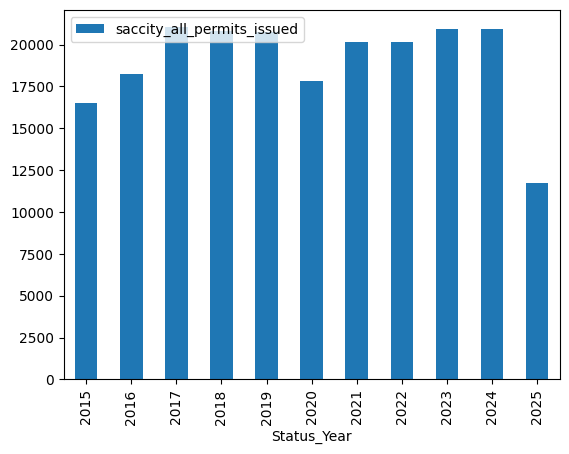

In [129]:
sql_string = """
select status_year, count(*) as saccity_all_permits_issued
from permits_saccity
group by status_year
order by status_year asc
"""
permits_saccity_by_year = duckdb.query(sql_string).df()
permits_saccity_by_year.plot(x='Status_Year', y=['saccity_all_permits_issued'], kind='bar')

<br><br><br>

# [Sac] Annotate permits with ADU hints

In [130]:
sql_string = """
SELECT *,
  
    Type in (
        'Residential'
    ) and Sub_Type in (
        'New Building'
    ) and Category in (
        'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,
    
FROM permits_saccity
"""

permits_saccity = duckdb.query(sql_string).df()

<br><br><br>

# [Sac] Plot Shelf-ready ADUs

<Axes: xlabel='Status_Year'>

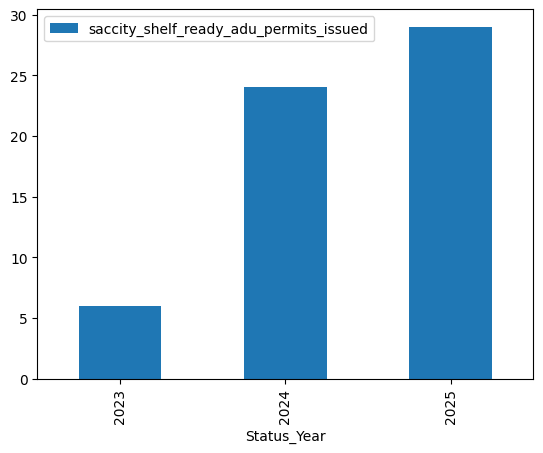

In [132]:
sql_string = """
SELECT Status_Year, count(*) as saccity_shelf_ready_adu_permits_issued
FROM permits_saccity
WHERE certainly_shelf_ready_adu
group by Status_Year 
having saccity_shelf_ready_adu_permits_issued > 1
order by Status_Year 
"""

saccity_shelf_ready_adu_permits_issued_by_year = duckdb.query(sql_string).df()
saccity_shelf_ready_adu_permits_issued_by_year.plot(
    x='Status_Year',
    y=['saccity_shelf_ready_adu_permits_issued'],
    kind='bar',
)

In [67]:
sql_string = """
WITH annotated AS (
  SELECT *,
  
    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,

    Type in (
      'Residential'
    )
    and Sub_Type in (
         'New Building'
    ) and Category in (
         'Single Family'
    ) and (
        Work_Desc ilike '%adu%'
        or Project_Name ilike '%adu%'
    ) as probably_adu,
    
  FROM permits_saccity
)

SELECT *
FROM annotated
WHERE not certainly_shelf_ready_adu and probably_adu
order by Status_Date desc
"""

probably_adu = duckdb.query(sql_string).df()
for x in probably_adu['Work_Desc']:
    print(x)

EPC - EXPEDITED - New 1 bed 1 bath 361 square foot Detached ADU on upper level with 275 square foot garage on lower level.Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“Any new landscaping done on this property is to be in compliance with the City’s Water Efficient Landscape Ordinance 15.92.”

Demo of 324 square feet, 1 story detached garage on issued permit RES-2500206.
EPC - New 555 s.f. Detached ADU with 1 Bedroom and 1 Bathroom. + 54 S/F Porch/Roof Covering, + 14 S/F Utility Closet with exterior door. Total project 623 S/F. This is a Primary record of Shared Plans. PV Exempt. 
Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).
“A